# Difference: 
## No multi-fold model aggregation
## Because quantile may change from different folds

# 0. Importing & Function definition

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
from scipy.interpolate import interp1d
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_pinball_loss
from sklearn.model_selection import KFold
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

from quantile_forest import RandomForestQuantileRegressor
import shap

import matplotlib
import matplotlib.pyplot as plt

import copy
import time
import logging
from typing import Optional

matplotlib.rcParams['font.family'] = 'Liberation Sans'

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)


class L1QR:
    def __init__(self, y: pd.Series, x: pd.DataFrame, alpha: float) -> None:
        """Python implementation of the L1 norm QR algorithm of
        Li and Zhu (2008): L1-Norm Quantile Regression, http://dx.doi.org/10.1198/106186008X289155

        Args:
            y: Vector of response data
            x: Matrix of covariates
            alpha: Quantile of interest
        """
        self.x = x.to_numpy()
        self.y = y.to_numpy()
        self.var_names = x.columns
        self.alpha = alpha

        # set by fit()
        self.beta0: Optional[np.array] = None
        self.beta: Optional[np.array] = None
        self.s: Optional[np.array] = None
        self.b0: Optional[pd.Series] = None
        self.b: Optional[pd.DataFrame] = None

    def fit(self, s_max: float = np.inf) -> None:
        """Estimate the model.

        Args:
            s_max: Stop the algorithm prematurely when the L1 norm of the slope coefficients reaches s_max
        """
        n, k = self.x.shape
        if self.y.size != n:
            raise Exception('y and x have different number of rows!')
        ####logger.info(f'Initialization lasso quantile regression for n={n}, k={k}, and alpha={self.alpha}')

        xc = np.hstack((np.ones((n, 1)), self.x))  # Store x a second time with intercept
        eps1 = 10 ** -10                           # Some low value
        eps2 = 10 ** -10                           # Convergence criterion
        max_steps = n * np.min((k, n - 1))         # Maximum number of steps for the algorithm
        ind_n = np.arange(n)                       # Index of the observations
        ind_k = np.arange(k)                       # Index of the variables
        beta0 = np.zeros((max_steps + 1, 1))       # Stores the estimates of the constant term
        beta = np.zeros((max_steps + 1, k))        # Stores the estimates of the slope parameters
        s = np.zeros(max_steps + 1)                # Stores the penalty parameter

        y_can_be_ordered_strictly = np.unique(self.y).size != n
        if y_can_be_ordered_strictly:
            ####logger.info('Adding noise to y because y contains duplicate values')
            self.y += np.random.normal(loc=0, scale=10 ** -5, size=self.y.size)

        ####logger.info('Finding initial solution')

        # There are actually two cases, first if n*tau is integer, second if tau*n is non-integer.
        # Here I assume that in the latter case all the weight is on the first component (see section 2.2)
        ini_beta0 = np.sort(self.y)[int(np.floor(self.alpha * n))]  # Initial beta0 (see 2.2.1)
        ini_beta = np.zeros(k)                                      # Initial beta (see 2.2.1)

        ind_e = np.array(int(np.argwhere(self.y == ini_beta0)))  # Index of the first point in the elbow
        ind_l = ind_n[self.y < self.y[ind_e]]                    # All points that are left of the elbow
        ind_r = ind_n[self.y > self.y[ind_e]]                    # All points that are right of the elbow
        residual = self.y - ini_beta0                            # Initial residuals

        # Add the first variable to the active set
        inactive = ind_k                                # All variables not in V
        tmp_e, tmp_l, tmp_r = ind_e, ind_l, ind_r       # Create a copy of the index sets
        lambda_var = np.zeros((2, inactive.size))       # First row: sign=1, second row: sign=-1
        lambda_var[lambda_var == 0] = -np.inf           # Initially set to -inf (want to maximize lambda)
        b = np.array([0, 1])                            # The 1_0 vector (see p. 171 bottom)
        nu_var = np.zeros((2, inactive.size, b.size))   # 3d array: nu for sign=1 in first dimension, sign=-1 in second

        for j_idx, j_star in enumerate(inactive):
            x_v = xc[:, np.append(0, j_star + 1)]

            # Sign of the next variable to include may be either positive or negative
            for sign in (1, -1):
                index = np.where(sign == 1, 0, 1)  # Index in nu_var and lambda_var

                # Combination of (2.10) and (2.11)
                x0 = np.vstack((np.hstack((1, np.mat(self.x)[tmp_e, j_star])), np.hstack((0, sign))))

                try:  # Check if x0 has full rank
                    nu_tmp = np.linalg.solve(x0, b)  # Solve system (p. 171 bottom)
                    nu_var[index, j_idx, :] = nu_tmp

                    # Store sets that are used to compute -lambda* (p. 172)
                    x_l = x_v.take(tmp_l, axis=0, mode='clip')
                    x_r = x_v.take(tmp_r, axis=0, mode='clip')

                    # Save lambda achieved by the current variable. If sign of last entry != sign then leave at -inf.
                    if np.sign(nu_tmp[-1]) == sign:
                        lambda_var[index, j_idx] = -((1 - self.alpha) * np.dot(x_l, nu_tmp).sum() -
                                                     self.alpha * np.dot(x_r, nu_tmp).sum())
                except LinAlgError:
                    pass
                    ####logger.debug(f'sign: {sign}')

        # Select the nu corresponding to the maximum lambda and store the maximum lambda
        nu_var = nu_var[lambda_var.argmax(axis=0), np.arange(inactive.size), :]
        lambda_var = lambda_var.max(axis=0)

        # Store the active variable
        ind_v = inactive[lambda_var.argmax()]

        # Store initial nu0 and nu
        nu0 = nu_var[ind_v, 0]
        nu = nu_var[ind_v, 1:]

        beta0[0] = ini_beta0
        beta[0] = ini_beta
        ####logger.debug(f'Initial beta0: {ini_beta0}')
        ####logger.debug(f'Initial beta: {ini_beta}')

        # Main loop
        ####logger.info('Entering main loop')
        drop = False
        idx = 0
        while idx < max_steps:
            ####logger.debug(f'Index: {idx}')
            idx += 1

            # Calculate how far we need to move (the minimum distance between points and elbow)
            if np.atleast_1d(nu).size == 1:  # Make sure scalar array is converted to float, causes problems with np.dot
                nu = np.float64(nu)

            # (2.14), nu0 + x'*nu where x is without i in elbow
            gam = nu0 + np.dot(self.x.take(ind_n[np.in1d(ind_n, ind_e, invert=True)], axis=0).take(ind_v, axis=1), nu)
            gam = np.ravel(gam)  # Flatten the array
            delta1 = np.delete(residual, ind_e, 0) / gam  # This is s - s_l in (2.14)

            # Check whether all points are in the elbow or if we still need to move on
            if np.sum(delta1 <= eps2) == delta1.size:
                delta = np.inf
            else:
                delta = delta1[delta1 > eps1].min()

            # Test if we need to remove some variable j from the active set
            if idx > 1:
                delta2 = np.array(-beta[idx - 1, ind_v] / nu)

                if np.sum(delta2 <= eps2) == delta2.size:
                    tmpz_remove = np.inf
                else:
                    tmpz_remove = delta2[delta2 > eps1].min()

                if tmpz_remove < delta:
                    drop = True
                    delta = tmpz_remove
                else:
                    drop = False

            # Check if we need to continue or if we are done
            if delta == np.inf:
                ####logger.info(f'Finished, delta = inf')
                break

            # Update the shrinkage parameter
            s[idx] = s[idx - 1] + delta

            # Prepare the next steps depending if we drop a variable or not
            if drop:
                tmp_delta = delta2[delta2 > eps1]  # All deltas larger than eps2
                tmp_ind = ind_v[delta2 > eps1]  # All V larger than eps2
                j1 = tmp_ind[tmp_delta.argmin()]  # The index of the variable to kick out
            else:
                # Find the i that will hit the elbow next
                tmp_ind = np.delete(ind_n, ind_e)[
                    delta1 > eps2]  # Remove Elbow from observations and keep non-zero elements
                tmp_delta = delta1[delta1 > eps2]  # All deltas that are non-zero
                i_star = tmp_ind[tmp_delta.argmin()]

            # Update beta
            beta0[idx] = beta0[idx - 1] + delta * nu0
            beta[idx] = beta[idx - 1]
            beta[idx, ind_v] = beta[idx - 1, ind_v] + delta * nu

            if s[idx] > s_max:
                ####logger.info(f's = {s[idx]:.2f} is large enough')
                break

            # Reduce residuals not in the elbow by delta*gam
            residual[np.in1d(ind_n, ind_e, invert=True)] -= delta * gam

            # Check if there are points in either L or R if we do not drop
            if (ind_l.size + ind_r.size == 1) & (not drop):
                ####logger.info('No point in L or R')
                break

            # Add a variable to the active set
            # Test if all variables are included. If yes, set lambda_var to -inf and continue with next step
            if ind_v.size == k:
                lambda_var = np.zeros((2, inactive.size))
                lambda_var[lambda_var == 0] = -np.inf
            else:
                inactive = ind_k[np.in1d(ind_k, ind_v, invert=True)]  # All variables not in V
                tmp_e, tmp_l, tmp_r = ind_e, ind_l, ind_r  # Create a copy of the index sets

                if drop:
                    ind_v = ind_v[ind_v != j1]  # Remove the detected variable from V
                else:
                    # Add i_star to the Elbow and remove it from either Left or Right
                    # (we know that i_star hits the elbow)
                    tmp_e = np.append(tmp_e, i_star)
                    tmp_l = tmp_l[tmp_l != i_star]
                    tmp_r = tmp_r[tmp_r != i_star]

                lambda_var = np.zeros((2, inactive.size))  # First row: sign=1, second row: sign=-1
                lambda_var[lambda_var == 0] = -np.inf  # Initially set to -inf (want to maximize lambda)
                nu_var = np.zeros((2, inactive.size, 1 + ind_v.size + 1))  # Store nus in 3d array
                b = np.array([0] * (ind_v.size + 1) + [1])  # The 1_0 vector (see p. 171 bottom)

                for j_idx in range(inactive.size):
                    j_star = inactive[j_idx]  # Select variable j as candidate for the next active variable

                    # Select all columns of x that are in ind_v and additionally j_star.
                    # Transposition improves performance as Python stores array in row-major order
                    x_v = xc.T.take(np.append(0, np.append(ind_v, j_star) + 1), axis=0, mode='clip').T

                    # Combination of (2.10) and (2.11)
                    x0 = np.vstack((np.hstack((np.ones((tmp_e.size, 1)),
                                               self.x[tmp_e][:, ind_v].reshape((tmp_e.size, -1)),
                                               self.x[tmp_e, j_star].reshape((tmp_e.size, -1)))),
                                    np.hstack(
                                        (0, np.sign(beta[idx, ind_v]), np.nan))))  # nan is a placeholder for sign

                    # Sign of the next variable to include may be either positive or negative
                    for sign in (1, -1):
                        index = np.where(sign == 1, 0, 1)  # Index in nu_var and lambda_var
                        x0[-1, -1] = sign  # Change sign in the x0 matrix

                        try:
                            nu_tmp = np.linalg.solve(x0, b)  # Solve system (p. 171 bottom)

                            # If sign of last entry != sign then leave at -inf.
                            if np.sign(nu_tmp[-1]) == sign:
                                nu_var[index, j_idx, :] = nu_tmp
                                # Store sets that are used to compute -lambda* (p. 172))
                                x_l = x_v.take(tmp_l, axis=0, mode='clip')
                                x_r = x_v.take(tmp_r, axis=0, mode='clip')
                                lambda_var[index, j_idx] = -((1 - self.alpha) * np.dot(x_l, nu_tmp).sum() -
                                                             self.alpha * np.dot(x_r, nu_tmp).sum())
                        except LinAlgError:
                            pass

                # Select the maximum of each column
                nu_var = nu_var[lambda_var.argmax(axis=0), np.arange(inactive.size), :]
                lambda_var = lambda_var.max(axis=0)

            # Remove an observation from the elbow
            lambda_obs = np.zeros(tmp_e.size)
            lambda_obs[lambda_obs == 0] = -np.inf
            nu_obs = np.zeros((1 + ind_v.size, tmp_e.size))
            left_obs = np.zeros(tmp_e.size)  # 1 if if we shifted observation to the left
            b = np.array([0] * ind_v.size + [1])

            # Store the L and the R observations of x
            x_v = xc.T.take(np.append(0, ind_v + 1), axis=0, mode='clip').T
            x_r = x_v.take(tmp_r, axis=0, mode='clip')
            x_l = x_v.take(tmp_l, axis=0, mode='clip')

            # Combination of (2.10) and (2.11), here without an additional variable j
            x0_all = np.vstack((np.hstack((np.ones((tmp_e.size, 1)), self.x[tmp_e][:, ind_v].reshape((tmp_e.size, -1)))),
                                np.hstack((0, np.sign(beta[idx, ind_v])))))

            for i in range(tmp_e.size):
                x0 = np.delete(x0_all, i, 0)  # Delete the ith observation
                try:
                    nu_tmp = np.linalg.solve(x0, b)  # Solve system (p. 171 bottom)
                    nu_obs[:, i] = nu_tmp
                    # Save lambda achieved by removing observation i
                    lambda_obs[i] = -((1 - self.alpha) * np.dot(x_l, nu_tmp).sum() -
                                      self.alpha * np.dot(x_r, nu_tmp).sum())

                    # Test if we shift i to the left or to the right
                    tmpyf = np.dot(np.append(1, self.x[tmp_e[i], ind_v]), nu_obs[:, i])
                    if tmpyf > 0:  # To the left
                        left_obs[i] = 1
                        lambda_obs[i] += -(1 - self.alpha) * tmpyf
                    else:  # To the right
                        lambda_obs[i] += self.alpha * tmpyf
                except LinAlgError:
                    pass

            # Compare the effects of adding one variable to V and removing one observation from E
            lam_var = lambda_var.max()  # Maximum lambda from adding a variable
            lam_obs = lambda_obs.max()  # Maximum lambda from removing an observation from E

            if (lam_var > lam_obs) & (lam_var > 0):  # Add variable to V
                lam = lam_var

                ind_v = np.append(ind_v, inactive[lambda_var.argmax()])

                if not drop:  # Add i_star to the elbow
                    ind_e = np.append(ind_e, i_star)
                    ind_l = ind_l[ind_l != i_star]
                    ind_r = ind_r[ind_r != i_star]

                # Store nu0 and nu
                nu0 = nu_var[lambda_var.argmax(), 0]
                nu = nu_var[lambda_var.argmax(), 1:]

            elif (lam_obs > lam_var) & (lam_obs > 0):  # Remove observation from E
                lam = lam_obs

                # i_star remains in E, no change in V
                if not drop:
                    ind_l = ind_l[ind_l != i_star]
                    ind_r = ind_r[ind_r != i_star]

                # Find a new i_star
                i_star = tmp_e[lambda_obs.argmax()]
                nu0 = nu_obs[0, lambda_obs.argmax()]
                nu = nu_obs[1:, lambda_obs.argmax()]

                # Test if we need to add i_star to L or R
                if left_obs[lambda_obs.argmax()] == 1:
                    ind_l = np.append(ind_l, i_star)
                else:
                    ind_r = np.append(ind_r, i_star)

                # Remove i_star from E
                ind_e = tmp_e[tmp_e != i_star]
            else:
                ####logger.info('No further descent')
                break

            # Check if descent is too small
            if np.abs(lam) < eps2:
                ####logger.info('Descent is small enough')
                break

            drop = False

        ####logger.info('Algorithm terminated')

        # Save the results
        self.beta0 = beta0[:idx][:, 0]
        self.beta = beta[:idx]
        self.s = s[:idx]
        self.var_names = self.var_names

        # Save the interpolated estimates
        s = np.linspace(self.s[0], self.s[-1], 1000)               # Interpolate shrinkage values
        b0 = pd.Series(np.interp(s, self.s, self.beta0), index=s)  # Extract and interpolate intercept
        b = pd.DataFrame(np.apply_along_axis(lambda w: np.interp(s, self.s, w), 0, self.beta),
                         index=s, columns=self.var_names)          # Extract and interpolate slope
        self.b0 = b0
        self.b = b

    def plot_trace(self, file_name=None, size=(8, 6)):
        """Plot the trace of the estimated coefficients

        Args:
            file_name: If None, the figure will be displayed
            size: (width, height) in inches

        """
        plt.ioff()

        b0, b = self.b0, self.b.copy()
        b.columns = [str(i + 1) + ' - ' + str(col) for i, col in enumerate(b.columns)]

        sns.set(style='white', rc={'font.family': 'serif'})

        fig = plt.figure(figsize=size)
        gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
        ax0, ax1 = plt.subplot(gs[0]), plt.subplot(gs[1])

        ax0.set_title("Trace Plot of the Lasso Quantile Regression")

        # Plot slopes
        b.plot(ax=ax0, legend=False, grid=False, linewidth=1.5, colormap='nipy_spectral')
        ax0.legend(loc='upper left', ncol=int(np.ceil(b.shape[1] / 6)),
                   framealpha=0.5, fancybox=True, labelspacing=0.1, columnspacing=0.5, fontsize=8)
        ax0.set_ylabel(r'Estimated Coefficients')

        # Plot intercept
        b0.plot(ax=ax1, legend=False, grid=False, style='gray')
        ax1.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(5))
        ax1.set_ylabel(r'Intercept')
        ax1.set_xlabel('Sum of the Absolute Slope Coefficients')

        # Add labels to right side
        for i in range(b.shape[1]):
            ax0.annotate(i + 1, xy=(ax0.get_xlim()[1], b.iloc[-1][i]), va='center', ha='left', size=7,
                         textcoords='offset points', xytext=(2, 0))

        # Tight layout and save
        sns.despine()
        if file_name is None:
            plt.show()
        else:
            plt.savefig(file_name,  bbox_inches='tight', pad_inches=0.02)
        plt.close('all')

    def predict(self, x: pd.DataFrame, s: Optional[float] = None) -> pd.Series:
        """Make a prediction.

        Args:
            x: A DataFrame with values to be predicted. The dimensions need to match
               the data used for training the model.
            s: The penalty parameter for which a prediction is returned.

        Returns:
            A Series with predictions for x.
        """
        if s < min(self.s) or s > max(self.s):
            print(self.s) ####!!!!
            raise ValueError(f's = {s} should be between '
                             f'{min(self.s):.2f} and {max(self.s):.2f}.')

        if set(self.b.columns) != set(x.columns):
            raise ValueError('The columns of b and x do not match!')

        x = x[self.b.columns]
        prediction = self.b0.to_numpy() + self.b.to_numpy().dot(x.to_numpy().T).T

        s0 = np.linspace(self.s[0], self.s[-1], 1000)
        p = pd.Series(np.apply_along_axis(lambda w: np.interp(s, s0, w), 1, prediction),
                      index=x.index)
        return p



In [21]:
def k_fold_CV_QRF(X, y, K=4, quantile=0.9, random_state=42):
    # Parameters: https://xgboost.readthedocs.io/en/latest/parameter.html
    n_estimators = [100, 200, 300] #[40, 60, 80, 100] # [5, 10, 20, 40]
    max_depth = [3, 5, 7, 9] # default: 6
    max_features = [1, 3, 6, 10]
    
    kf = KFold(n_splits=K, shuffle=True, random_state=random_state)

    #best_metric = 1.0 #start from baseline
    best_params = {} #{"n_estimator": [], "max_depth": [], "max_features": [], "MAE": []}
    best_pinball_score = np.inf
    
    #print("Cross validating ...")
    start_time = time.time()
    
    for nEs in n_estimators:
        for maxD in max_depth:
            for n_feat in max_features:
                pinball_scores = []
                model = RandomForestQuantileRegressor(n_estimators=nEs,
                                                      max_depth=maxD,
                                                      max_features=n_feat,
                                                      random_state=random_state,
                                                      default_quantiles=quantile)

                # Perform k-fold cross-validation
                for train_index, val_index in kf.split(X):
                    X_train_KF, X_val_KF = X.iloc[train_index], X.iloc[val_index]
                    y_train_KF, y_val_KF = y.iloc[train_index], y.iloc[val_index]
                    #X_train_KF, X_val_KF = X[train_index], X[val_index]
                    #y_train_KF, y_val_KF = y[train_index], y[val_index]

                    # Fit the model
                    model.fit(X_train_KF, y_train_KF)

                    # Predict on the test set
                    y_pred = model.predict(X_val_KF)

                    # Calculate and store the mean squared error
                    #rmse = np.sqrt(mean_squared_error(y_val_KF, y_pred))
                    #rmse_scores.append(rmse)
                    pinball = mean_pinball_loss(y_val_KF, y_pred, alpha=quantile)
                    pinball_scores.append(pinball)

                pinball_score = np.mean(pinball_scores)
                
                if pinball_score < best_pinball_score:
                    params = {"n_estimator":nEs,"max_depth":maxD,"max_features":n_feat,"Pinball":pinball_score}
                    best_pinball_score = pinball_score
                                
    #print("Cross validation completed!")
    end_time = time.time()
    
    print("Execution time:", end_time - start_time, "s")
    
    return params

In [22]:
def get_shap_values(qrf, X, quantile=0.5, **kwargs):
    """Get QRF model SHAP values using Tree SHAP.

    Note that, at the time of writing, SHAP does not natively provide support
    for models in which quantile estimation is applied during inference, such
    as with QRFs. To address this limitation, this function adjusts the
    explainer outputs based on the difference between the mean and quantile
    predictions for each sample, creating new base and expected values.

    Parameters
    ----------
    qrf : BaseForestQuantileRegressor
        Quantile forest model object.
    X : array-like, of shape (n_samples, n_features)
        Input dataset for which SHAP values are calculated.
    quantiles : float, default=0.5
        Quantile for which SHAP values are calculated.

    Returns
    -------
    shap.Explanation: The SHAP values explanation object.
    """
    # Define a custom tree model.
    model = {
        "objective": qrf.criterion,
        "tree_output": "raw_value",
        "trees": [e.tree_ for e in qrf.estimators_],
    }

    # Use Tree SHAP to generate explanations.
    explainer = shap.TreeExplainer(model, X)

    qrf_pred = qrf.predict(X, quantiles=quantile, **kwargs)
    rf_pred = qrf.predict(X, quantiles="mean", aggregate_leaves_first=False)

    scaling = 1.0 / len(qrf.estimators_)  # scale factor based on the number of estimators
    base_offset = qrf_pred - rf_pred  # difference between the QRF and RF (baseline) predictions

    # Adjust the tree model values.
    explainer.model.values *= scaling  # multiply based on the scaling

    # Adjust the explainer expected value.
    explainer.expected_value *= scaling  # multiply based on the scaling
    explainer.expected_value = np.tile(explainer.expected_value, len(X))  # tile to length of X
    explainer.expected_value += np.array(base_offset)  # adjust based on the quantile

    shap_values = explainer(X, check_additivity=False)
    shap_values.base_values = np.diag(shap_values.base_values)

    return shap_values

def train_model_QRF(params, X, y, quantile=0.9, random_state=42):
    qrf = RandomForestQuantileRegressor(n_estimators=params["n_estimator"],
                                          max_depth=params["max_depth"],
                                          max_features=params["max_features"],
                                          random_state=random_state,
                                          default_quantiles=quantile)
    
    qrf.fit(X, y)
    
    importances = qrf.feature_importances_
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

    # Solution from: https://github.com/shap/shap/issues/3703
    #model = RandomForestRegressor(random_state=random_state)
    #model.estimators_ = qrf.estimators_
    #explainer = shap.TreeExplainer(model)
    #shap_values = explainer.shap_values(X)
    
    # Solution from: https://zillow.github.io/quantile-forest/gallery/plot_qrf_treeshap_explanations.html
    shap_values = get_shap_values(qrf, X, quantile)
    
    return qrf, feature_importances, shap_values

In [23]:
def plot_ICE(pdp_result, model, X, feature):
    # Extract ICE and PDP values
    xx = pdp_result['values'][0]  # Feature grid points
    ice_curves = pdp_result['individual'][0]  # ICE curves (n_samples x len(xx))
    pdp_curve = pdp_result['average'][0]  # PDP curve

    # 3. Plot PDP and ICE
    plt.figure(figsize=(8, 6))

    # Plot ICE curves
    for i in range(ice_curves.shape[0]):
        plt.plot(xx, ice_curves[i], color='lightblue', alpha=0.8, lw=0.7)

    # Plot PDP curve
    plt.plot(xx, pdp_curve, color='blue', label='PDP', lw=2)

    # 4. Overlay sample points
    # For each sample, plot its feature value against its predicted output
    feature_values = X[feature]
    predictions = model.predict(X)

    plt.scatter(feature_values, predictions, color='red', alpha=0.6, s=10, label='Samples')

    # 5. Customize plot
    plt.xlabel(feature)
    plt.ylabel('Partial Dependence / ICE')
    plt.title(f'PDP and ICE for {feature}')
    plt.legend()
    plt.grid(alpha=0.5)

# 1. Load data

In [24]:
data_M_imp = pd.read_csv("data_M_imp.csv")
data_F_imp = pd.read_csv("data_F_imp.csv")

y_M_effe = data_M_imp['d_resEffe'].reset_index(drop=True)
y_M_offi = data_M_imp['d_resOffi'].reset_index(drop=True)
y_F_effe = data_F_imp['d_resEffe'].reset_index(drop=True)
y_F_offi = data_F_imp['d_resOffi'].reset_index(drop=True)

X_M = data_M_imp.drop(columns=['d_resEffe','d_resOffi']).reset_index(drop=True)
X_F = data_F_imp.drop(columns=['d_resEffe','d_resOffi']).reset_index(drop=True)

In [25]:
X_all = X_M
y = y_M_effe

quantile = 0.9

# 2. Feature selection

In [26]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X_all)

X_all_scaled_df = pd.DataFrame(X_scaled, columns=X_all.columns)

In [27]:
N = 100  # Number of steps
K = 3  # Number of fold
Nr = 5  # Random seeds number

#s_list = np.logspace(-4, 1, N)
pinball_scores = []
betas = []

start_time = time.time()

for seed in range(40,40+Nr):
    kf = KFold(n_splits=K, shuffle=True, random_state=seed)
    
    for train_index, val_index in kf.split(X_all_scaled_df):
        pinball_loss = []
        
        X_train_KF, X_val_KF = X_all_scaled_df.iloc[train_index], X_all_scaled_df.iloc[val_index]
        y_train_KF, y_val_KF = y.iloc[train_index], y.iloc[val_index]

        # Estimate the lasso quantile regression
        mdl = L1QR(y=y_train_KF, x=X_train_KF, alpha=quantile)
        mdl.fit(s_max=11)
        
        betas.append(mdl.b)
            
        for i,s in enumerate(mdl.b.index):
            y_pred = mdl.predict(x=X_val_KF, s=s)
            pinball_loss.append(mean_pinball_loss(y_val_KF, y_pred, alpha=quantile))
        
        pinball_scores.append(pinball_loss)

end_time = time.time()
elapsed_time = end_time - start_time  # Calculate elapsed time in seconds
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 10.0014 seconds


In [28]:
s_max = []
for i in range(len(betas)):
    s_max.append(max(betas[i].index))
print(s_max)

s_minmax = min(s_max)*0.99

N = 100
s_list = np.logspace(-1, np.log10(s_minmax), N)

beta_new = pd.DataFrame()

for cn in betas[0].columns:
    arr = np.zeros(N)
    for i in range(len(betas)):
        interpolation_function = interp1d(np.array(betas[i].index), betas[i][cn], kind='linear')
        values_interpolated = interpolation_function(s_list)
        arr += values_interpolated
    beta_new[cn] = arr/len(betas)

pinball_score_new = np.zeros(N)
for i in range(len(pinball_scores)):
    interpolation_function = interp1d(np.array(betas[i].index), np.array(pinball_scores[i]), kind='linear')
    values_interpolated = interpolation_function(s_list)
    pinball_score_new += values_interpolated
pinball_score_new /= len(pinball_scores)

[5.835622247189782, 6.836093924807861, 8.90740605783515, 8.889988707575691, 6.823635322542346, 6.430549562581184, 8.161736727573441, 10.991971689896456, 9.047607414335037, 8.399962865887556, 7.215667927615713, 7.6611644167777895, 8.135032683024825, 8.308715077103143, 6.009486735595502]


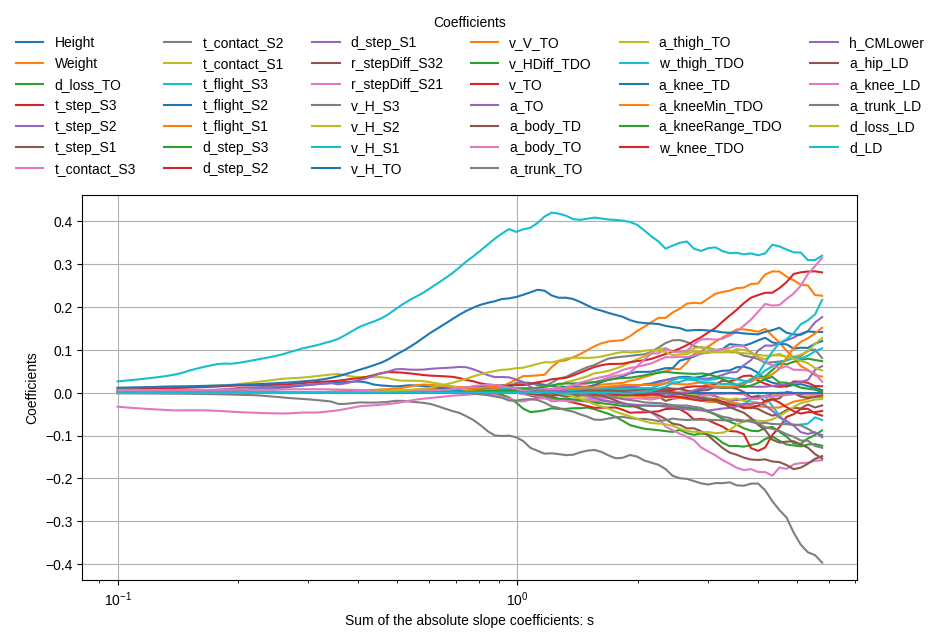

In [29]:
fig, ax1 = plt.subplots(figsize=(10,5))

lines = []
labels = []

for cn in beta_new.columns:
    line, = ax1.plot(s_list, np.array(beta_new[cn]), label=cn)  # Capture the line object
    lines.append(line)  # Add line to the handles list
    labels.append(cn)   # Add column name to the labels list
    
ax1.set_xscale('log')
ax1.set_xlabel('Sum of the absolute slope coefficients: s')
ax1.set_ylabel('Coefficients')
ax1.legend(lines, labels, title="Coefficients", loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=6, frameon=False)

ax1.grid()

#plt.tight_layout()

In [30]:
idx_best = np.argmin(pinball_score_new)

counts = np.count_nonzero(beta_new.values, axis=1)

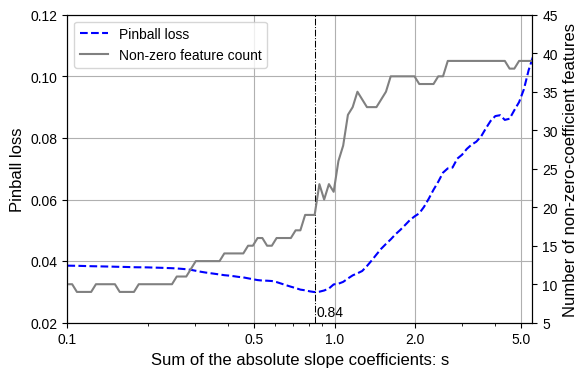

In [31]:
fig, ax1 = plt.subplots(figsize=(6,4))
line1, = ax1.plot(s_list, pinball_score_new, linestyle='--', color='blue')
ax1.set_xlim((0.1,5.5))
ax1.set_ylim((0.02,0.12))
ax1.set_xscale('log')
#ax1.xaxis.set_major_locator(plt.MultipleLocator(0.5))  # Major ticks every 0.5
#ax1.set_xticks([0.1, 0.5, 1.0, s_list[idx_best], 2.0, 5.0])  # Specify exact tick positions
#ax1.set_xticklabels(['0.1', '0.5', '1.0', "{:.3g}".format(s_list[idx_best]), '2.0', '5.0'])  # Custom labels (optional)
ax1.set_xticks([0.1, 0.5, 1.0, 2.0, 5.0])
ax1.set_xticklabels(['0.1', '0.5', '1.0', '2.0', '5.0'])  # Custom labels (optional)

idx_select = idx_best
plt.axvline(x=s_list[idx_select], color='black', linestyle='-.', label='x = 3', linewidth=0.75)
plt.text(s_list[idx_select]+0.12, plt.ylim()[0]+0.002, '{:.2f}'.format(s_list[idx_select]), color='black', ha='center')

ax1.set_xlabel('Sum of the absolute slope coefficients: s', fontsize=12)
ax1.set_ylabel('Pinball loss', fontsize=12)
ax1.grid()

ax2 = ax1.twinx()
line2, = ax2.plot(s_list, counts, color='gray')
ax2.set_ylim((5,45))
ax2.set_ylabel('Number of non-zero-coefficient features', fontsize=12)

lines = [line1, line2]
labels = ['Pinball loss', 'Non-zero feature count']
ax1.legend(lines, labels, loc='upper left')

In [32]:
feature_abs_coefficients = beta_new.iloc[idx_select].abs()
ranked_features = feature_abs_coefficients.sort_values(ascending=False)

selected_features = list(ranked_features.index[ranked_features.values>0])
print(selected_features)

['v_H_S1', 'a_knee_TD', 't_contact_S2', 'd_loss_LD', 'h_CMLower', 'v_TO', 'a_knee_LD', 'Height', 't_flight_S1', 'Weight', 't_flight_S2', 'v_H_S3', 'a_trunk_TO', 'v_V_TO', 'a_kneeRange_TDO', 'r_stepDiff_S21', 't_flight_S3', 'w_thigh_TDO', 'v_H_S2']


# 3. Quantile random forest regression

In [33]:
X = X_all[selected_features]

In [34]:
params = k_fold_CV_QRF(X, y, K=4, quantile=quantile)
print(params)

Execution time: 23.37884497642517 s
{'n_estimator': 100, 'max_depth': 3, 'max_features': 6, 'Pinball': 0.028740902777777782}


In [35]:
#model_v1, feature_importances_v1, explainer_v1 = train_model_QRF_v1(params_MS, X_MS, y_M, quantile=0.8)
qrf, _, shap_res = train_model_QRF(params, X, y, quantile=quantile)

## 3.1 SHAP analysis

### Global

In [36]:
feature_ranked_shap = pd.DataFrame({'Features': X.columns, 
                                    'SHAP': np.mean(np.abs(shap_res.values),axis=0)}).sort_values(by='SHAP', 
                                                                                                  ascending=False)
display(feature_ranked_shap)

,Features,SHAP
0,v_H_S1,0.071032
1,a_knee_TD,0.020936
13,v_V_TO,0.015451
5,v_TO,0.011557
2,t_contact_S2,0.011429
11,v_H_S3,0.011068
18,v_H_S2,0.010696
10,t_flight_S2,0.010567
14,a_kneeRange_TDO,0.010352
17,w_thigh_TDO,0.006891


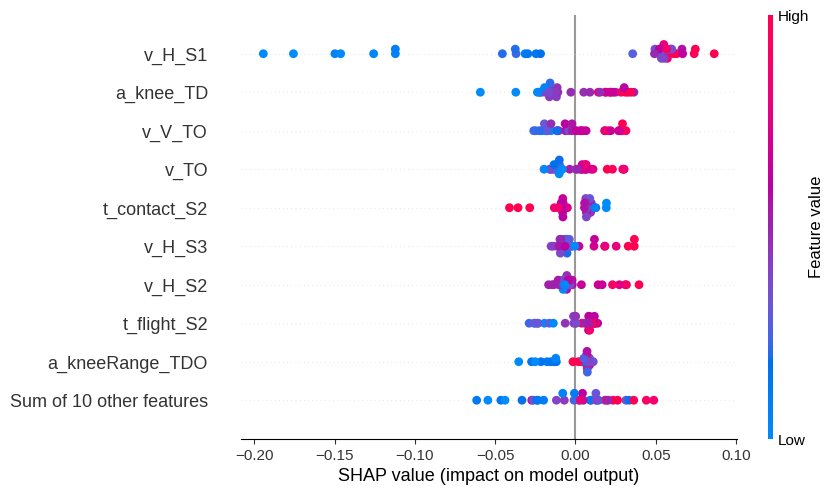

In [37]:
# shap.summary_plot(shap_res, X, max_display=10)
shap.plots.beeswarm(shap_res, max_display=10, s=40)
#shap.plots.bar(shap_res, show_data=True)

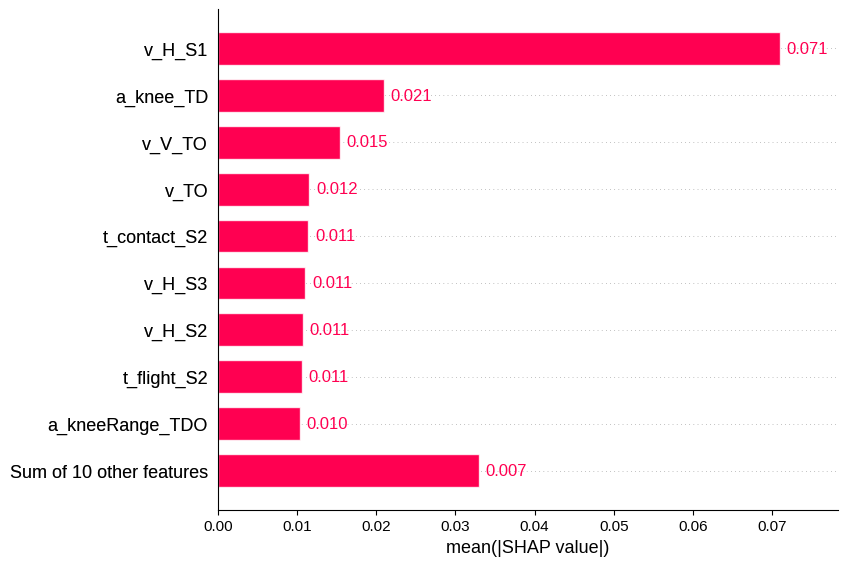

In [38]:
shap.plots.bar(shap_res, show_data=False, show=False)
ax = plt.gca()  # Get the current axis
for i, (patch, text) in enumerate(zip(ax.patches, ax.texts)):
    # `patch` is the bar, `text` is the default label
    new_label = f"{list(feature_ranked_shap['SHAP'])[i]:.3f}"  # Example: Modify to 2 decimal places
    text.set_text(new_label)
    #text.set_color("blue")  # Optional: Change the text color
    #text.set_fontsize(10)  # Optional: Change font size
    #text.set_fontweight("bold")  # Optional: Make bold

# Show the updated plot
plt.show()

### Individual

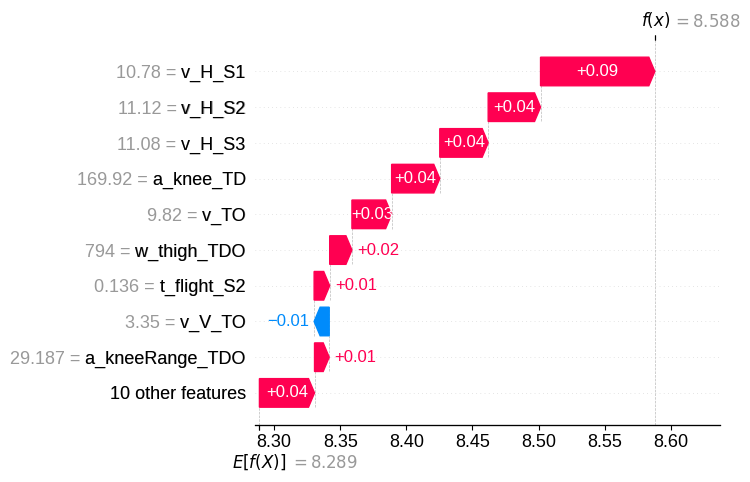

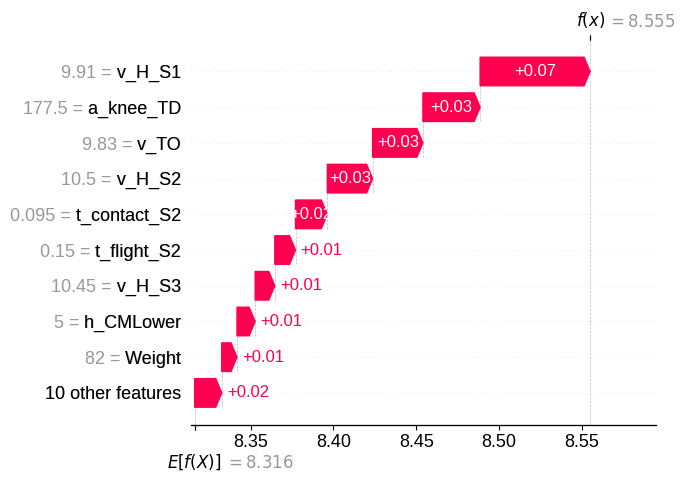

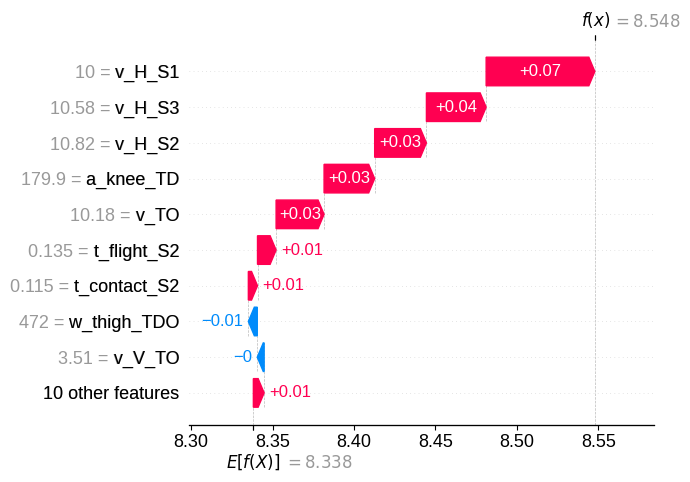

In [39]:
index_descending = np.argsort(y)[::-1].to_list()

for i in index_descending[:3]:
    shap_tmp = copy.deepcopy(shap_res[i])
    shap_tmp.base_values = shap_res[i].base_values[i]
    
    shap.plots.waterfall(shap_tmp, show=False)
    current_fig = plt.gcf()
    current_fig.set_size_inches(6, 5)
    
    plt.show()

In [40]:
print(y[index_descending])

27    8.590
15    8.540
16    8.500
0     8.487
28    8.480
1     8.442
29    8.440
18    8.350
17    8.350
30    8.330
21    8.320
19    8.270
22    8.260
20    8.260
3     8.233
31    8.230
4     8.211
5     8.202
23    8.200
2     8.190
33    8.140
24    8.100
34    8.100
32    8.070
6     8.050
8     8.026
25    8.000
7     7.947
26    7.930
9     7.910
10    7.804
12    7.789
11    7.765
13    7.597
14    7.541
Name: d_resEffe, dtype: float64


## 3.2 PDP & ICE plots

In [23]:
Units = {'d_resOffi': 'm', 'd_resEffe':'m',
         'v_H_S1': 'm/s', 'v_H_S2': 'm/s', 'v_H_S3': 'm/s', 'v_H_TO': 'm/s', 'v_V_TO': 'm/s', 'v_TO': 'm/s',
         'a_knee_TD': '°', 'a_kneeRange_TDO': '°', 
         'a_knee_LD': 'm', 'd_LD': 'm'
        }

In [34]:
def plot_ICE(pdp_result, model, X, feature, unit=''):
    # Extract ICE and PDP values
    xx = pdp_result['grid_values'][0]  # Feature grid points
    ice_curves = pdp_result['individual'][0]  # ICE curves (n_samples x len(xx))
    pdp_curve = pdp_result['average'][0]  # PDP curve

    # 3. Plot PDP and ICE
    plt.figure(figsize=(6, 4))

    # Plot ICE curves
    for i in range(ice_curves.shape[0]):
        plt.plot(xx, ice_curves[i], color='lightblue', alpha=0.6, lw=0.7)

    # Plot PDP curve
    plt.plot(xx, pdp_curve, color='blue', label='PDP (average)', lw=2)

    # 4. Overlay sample points
    # For each sample, plot its feature value against its predicted output
    feature_values = X[feature]
    predictions = model.predict(X)

    plt.scatter(feature_values, predictions, color='red', alpha=1, s=20, label='Samples')

    # 5. Customize plot
    if len(unit)==0:
        plt.xlabel(feature, fontsize=12)
    else:
        plt.xlabel(feature+' ({})'.format(unit), fontsize=12)
    plt.ylabel('Distance contribution (m)', fontsize=12)
    plt.title(f'ICE plot for {feature}')
    plt.legend()
    plt.grid(alpha=0.4)
    
    plt.show()

### ICE plots

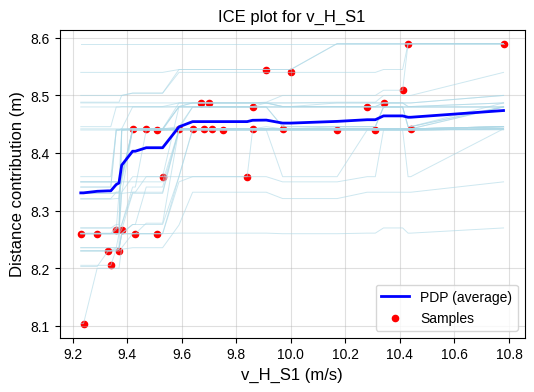

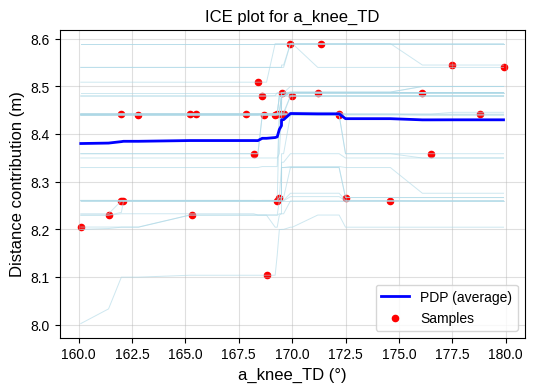

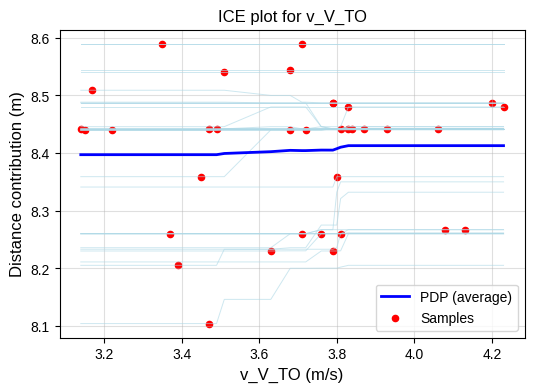

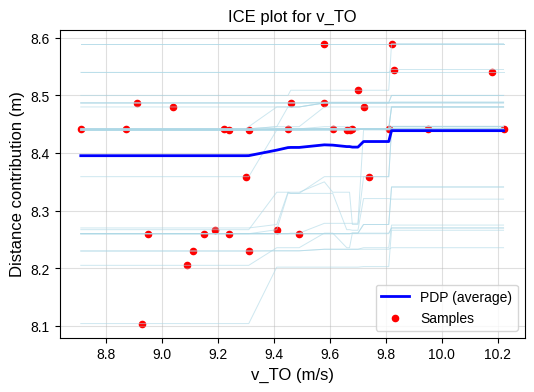

In [35]:
for fn in feature_ranked_shap['Features'][:4]:
    pdp_result = partial_dependence(qrf, X, [fn], kind='both')
    plot_ICE(pdp_result, qrf, X, fn, Units[fn])
    plt.show()

/tmp/ipykernel_5391/2446249360.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Effective distance (m)',shrink=1, aspect=40)


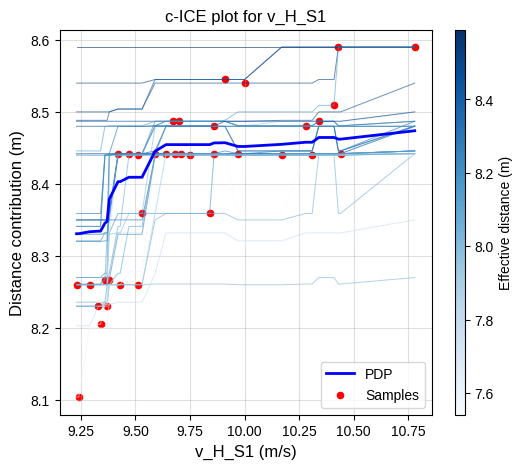

/tmp/ipykernel_5391/2446249360.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Effective distance (m)',shrink=1, aspect=40)


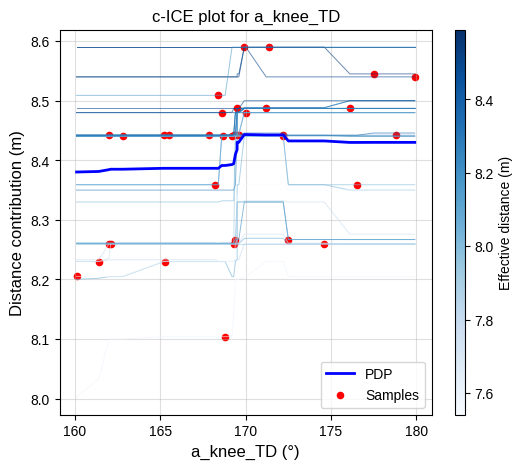

/tmp/ipykernel_5391/2446249360.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Effective distance (m)',shrink=1, aspect=40)


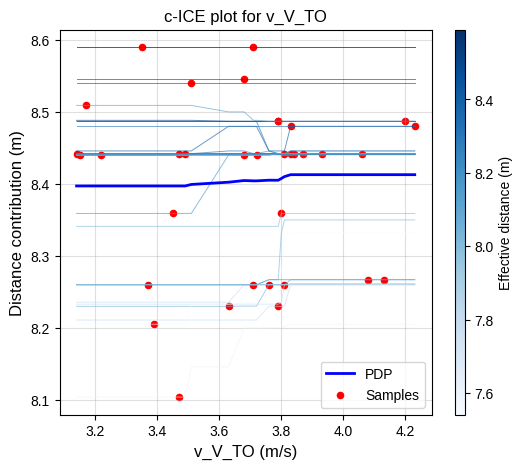

/tmp/ipykernel_5391/2446249360.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Effective distance (m)',shrink=1, aspect=40)


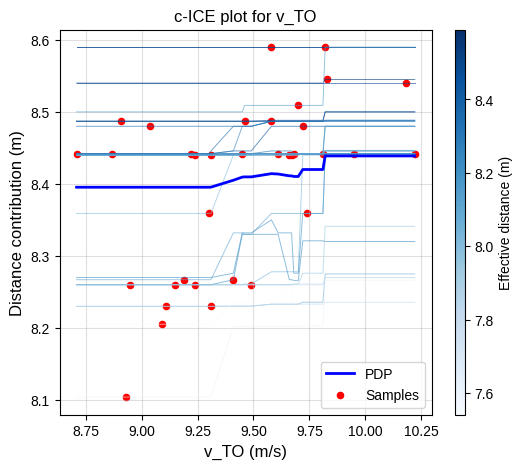

In [320]:
for fn in feature_ranked_shap['Features'][:4]:
    pdp_result = partial_dependence(qrf, X, [fn], kind='both')
    plot_ICE(pdp_result, qrf, X, y, fn, Units[fn])
    plt.show()

### 2D PDP

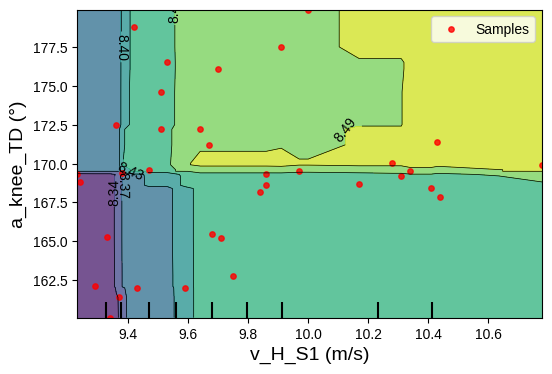

In [350]:
feature_pair = ('v_H_S1', 'a_knee_TD')
id_f0 = selected_features.index(feature_pair[0])
id_f1 = selected_features.index(feature_pair[1])
PartialDependenceDisplay.from_estimator(qrf, X, [(id_f0, id_f1)], kind='average')

fig = plt.gcf()
fig.set_size_inches(6, 4)

plt.scatter(X[feature_pair[0]],X[feature_pair[1]], color='red', alpha=0.8, s=15, label='Samples')
plt.legend()

plt.gca()
plt.xlabel(feature_pair[0]+' ({})'.format(Units[feature_pair[0]]), fontsize=14)
plt.ylabel(feature_pair[1]+' ({})'.format(Units[feature_pair[1]]), fontsize=14)

plt.show()

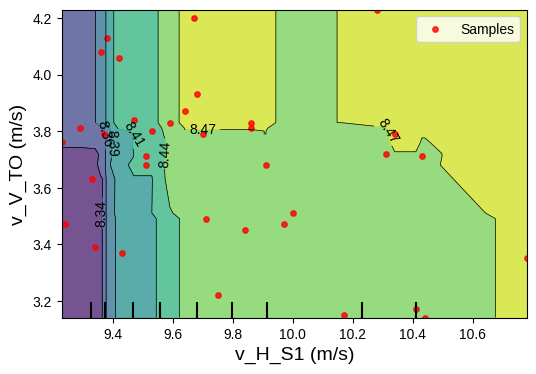

In [351]:
feature_pair = ('v_H_S1', 'v_V_TO')
id_f0 = selected_features.index(feature_pair[0])
id_f1 = selected_features.index(feature_pair[1])
PartialDependenceDisplay.from_estimator(qrf, X, [(id_f0, id_f1)], kind='average')

fig = plt.gcf()
fig.set_size_inches(6, 4)

plt.scatter(X[feature_pair[0]],X[feature_pair[1]], color='red', alpha=0.8, s=15, label='Samples')
plt.legend()

plt.gca()
plt.xlabel(feature_pair[0]+' ({})'.format(Units[feature_pair[0]]), fontsize=14)
plt.ylabel(feature_pair[1]+' ({})'.format(Units[feature_pair[1]]), fontsize=14)

plt.show()

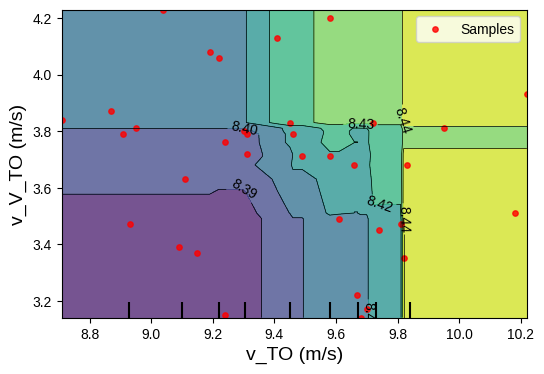

In [352]:
feature_pair = ('v_TO', 'v_V_TO')
id_f0 = selected_features.index(feature_pair[0])
id_f1 = selected_features.index(feature_pair[1])
PartialDependenceDisplay.from_estimator(qrf, X, [(id_f0, id_f1)], kind='average')

fig = plt.gcf()
fig.set_size_inches(6, 4)

plt.scatter(X[feature_pair[0]],X[feature_pair[1]], color='red', alpha=0.8, s=15, label='Samples')
plt.legend()

plt.gca()
plt.xlabel(feature_pair[0]+' ({})'.format(Units[feature_pair[0]]), fontsize=14)
plt.ylabel(feature_pair[1]+' ({})'.format(Units[feature_pair[1]]), fontsize=14)

plt.show()